# Postprocessing and Model Building

In [1]:
import os
import pickle
import json
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns

In [2]:
main_filepath = '/projects/kernlab/akapoor/Demographic_Inference'

CONFIG_FILEPATH = f'{main_filepath}/experiment_config.json'
MODEL_CONFIG_FILEPATH = f'{main_filepath}/model_config.json'

with open(CONFIG_FILEPATH, 'r') as f:
   experiment_config = json.load(f)

with open(MODEL_CONFIG_FILEPATH, 'r') as f:
   model_config = json.load(f)


CWD = os.getcwd()

# Use double quotes for the dictionary keys inside the f-string
EXPERIMENT_DIRECTORY = f"{experiment_config['demographic_model']}_dadi_analysis_{experiment_config['dadi_analysis']}_moments_analysis_{experiment_config['moments_analysis']}_momentsLD_analysis_{experiment_config['momentsLD_analysis']}_seed_{experiment_config['seed']}"
EXPERIMENT_NAME = f'sims_pretrain_{experiment_config["num_sims_pretrain"]}_sims_inference_{experiment_config["num_sims_inference"]}_seed_{experiment_config["seed"]}_num_replicates_{experiment_config["k"]}_top_values_{experiment_config["top_values_k"]}'
SIM_DIRECTORY = f"{EXPERIMENT_DIRECTORY}/sims/{EXPERIMENT_NAME}"

# Check if hidden_size is a list, and if so, join the elements with "_"
hidden_size = model_config['neural_net_hyperparameters']['hidden_size']
if isinstance(hidden_size, list):
    hidden_size_str = "_".join(map(str, hidden_size))  # Join list elements with "_"
else:
    hidden_size_str = str(hidden_size)  # Convert integer to string if not a list

# Build the MODEL_DIRECTORY string
MODEL_DIRECTORY = (
    f"{EXPERIMENT_DIRECTORY}/models/{EXPERIMENT_NAME}/"
    f"num_hidden_neurons_{hidden_size_str}_"
    f"num_hidden_layers_{model_config['neural_net_hyperparameters']['num_layers']}_"
    f"num_epochs_{model_config['neural_net_hyperparameters']['num_epochs']}_"
    f"dropout_value_{model_config['neural_net_hyperparameters']['dropout_rate']}_"
    f"weight_decay_{model_config['neural_net_hyperparameters']['weight_decay']}_"
    f"batch_size_{model_config['neural_net_hyperparameters']['batch_size']}_"
    f"EarlyStopping_{model_config['neural_net_hyperparameters']['EarlyStopping']}"
)


In [3]:
os.chdir('/projects/kernlab/akapoor/Demographic_Inference/')
os.environ['PYTHONPATH'] = '/projects/kernlab/akapoor/Demographic_Inference:' + os.environ.get('PYTHONPATH', '')

Just to check again, I want to look at the results for preprocessing

In [4]:
with open(os.path.join('/projects/kernlab/akapoor/Demographic_Inference',f'{SIM_DIRECTORY}', 'preprocessing_results_obj.pkl'), 'rb') as f:
    preproc = pickle.load(f)

In [5]:
preproc['training']['indices'][0]

3052

In [6]:
preproc['training']['predictions'].columns

Index(['dadi_rep1_N0', 'moments_rep1_N0', 'moments_rep1_FIM_element_0',
       'moments_rep1_FIM_element_1', 'moments_rep1_FIM_element_2',
       'moments_rep1_FIM_element_3', 'moments_rep1_FIM_element_4',
       'moments_rep1_FIM_element_5', 'moments_rep1_FIM_element_6',
       'moments_rep1_FIM_element_7', 'moments_rep1_FIM_element_8',
       'moments_rep1_FIM_element_9', 'dadi_rep1_Nb', 'moments_rep1_Nb',
       'dadi_rep1_N_recover', 'moments_rep1_N_recover',
       'dadi_rep1_t_bottleneck_start', 'moments_rep1_t_bottleneck_start',
       'dadi_rep1_t_bottleneck_end', 'moments_rep1_t_bottleneck_end',
       'dadi_rep2_N0', 'moments_rep2_N0', 'moments_rep2_FIM_element_0',
       'moments_rep2_FIM_element_1', 'moments_rep2_FIM_element_2',
       'moments_rep2_FIM_element_3', 'moments_rep2_FIM_element_4',
       'moments_rep2_FIM_element_5', 'moments_rep2_FIM_element_6',
       'moments_rep2_FIM_element_7', 'moments_rep2_FIM_element_8',
       'moments_rep2_FIM_element_9', 'dadi_rep2_

In [7]:
import pandas as pd

# Assuming preproc['training']['predictions'] is a DataFrame
predictions_df = preproc['training']['predictions']

# Count rows with at least one NaN value
rows_with_nan = predictions_df.isna().any(axis=1).sum()

print(f"Number of rows with at least one NaN value: {rows_with_nan}")


Number of rows with at least one NaN value: 0


In [8]:
preproc['training']['predictions']['moments_rep1_N0']

0       9754.190010
1       9175.082477
2       9688.079053
3       8172.555975
4       9403.778880
           ...     
3795    8372.034258
3796    9889.722341
3797    9778.294588
3798    9994.478212
3799    8248.233899
Name: moments_rep1_N0, Length: 3800, dtype: float64

In [9]:
np.max(preproc['training']['targets']['simulated_params_N0'])

9999

In [10]:
np.min(preproc['training']['targets']['simulated_params_N0'])

8000

In [11]:
preproc['training']['targets']['simulated_params_N0']

0       9773
1       9202
2       9829
3       8280
4       9412
        ... 
3795    8435
3796    9686
3797    9685
3798    9915
3799    8375
Name: simulated_params_N0, Length: 3800, dtype: int64

In [12]:
preproc['training']['predictions']['dadi_rep1_N0']

0       9702.694916
1       9121.189512
2       9671.653561
3       8107.696297
4       9317.808880
           ...     
3795    8311.065828
3796    9828.834232
3797    9653.569808
3798    9929.222851
3799    8308.919040
Name: dadi_rep1_N0, Length: 3800, dtype: float64

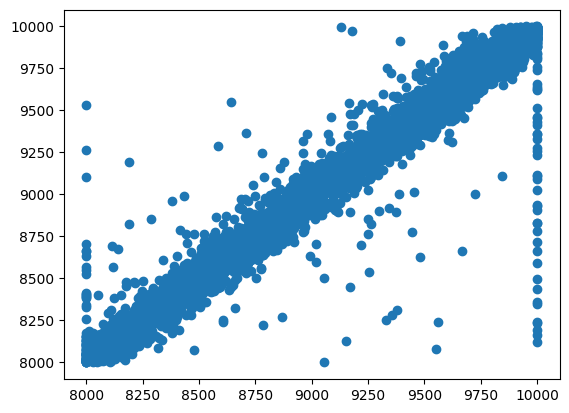

In [13]:
import matplotlib.pyplot as plt
plt.scatter(preproc['training']['predictions']['moments_rep1_N0'], preproc['training']['targets']['simulated_params_N0'])
# Set the zoomed-in range for the axes
# # Show the zoomed-in plot
# plt.show()
plt.show()

In [14]:
with open('/projects/kernlab/akapoor/Demographic_Inference/moments_dadi_features/software_inferences_sim_810.pkl', 'rb') as f:
    a = pickle.load(f)

In [15]:
a['simulated_params']

{'N0': 8636,
 'Nb': 4680,
 'N_recover': 6822,
 't_bottleneck_start': 1935,
 't_bottleneck_end': 869}

In [17]:
a['opt_params_dadi']

[{'N0': 8582.196061915745,
  'Nb': 5939.338833567194,
  'N_recover': 8611.300802609909,
  't_bottleneck_start': 2760.9490443799727,
  't_bottleneck_end': 2660.7478485867177,
  'll': -234.12409080016187},
 {'N0': 8584.315605011348,
  'Nb': 5940.873922714455,
  'N_recover': 8522.531392671215,
  't_bottleneck_start': 2769.6681167824727,
  't_bottleneck_end': 2667.2350138281904,
  'll': -234.1326764155301}]

## Postprocessing

In [18]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/postprocessing.py \
    --config_file $CONFIG_FILEPATH \
    --training_features_filepath $SIM_DIRECTORY/training_features.csv \
    --training_targets_filepath $SIM_DIRECTORY/training_targets.csv \
    --validation_features_filepath $SIM_DIRECTORY/validation_features.csv \
    --validation_targets_filepath $SIM_DIRECTORY/validation_targets.csv \
    --sim_directory $SIM_DIRECTORY



Processing training data:
===> Normalizing the data.

Processing validation data:
===> Normalizing the data.
Postprocessing dict keys: dict_keys(['normalization', 'predictions', 'normalized_predictions', 'targets', 'normalized_targets'])
Postprocessing complete!


In [19]:
with open(os.path.join('/projects/kernlab/akapoor/Demographic_Inference',f'{SIM_DIRECTORY}', 'postprocessing_results.pkl'), 'rb') as f:
    post = pickle.load(f)

In [20]:
post['training']['normalized_predictions']['dadi_rep1_t_bottleneck_end']

0       1.732051
1      -1.732051
2      -1.732051
3      -1.732051
4       1.732051
          ...   
3795   -1.732051
3796    1.732051
3797    1.732051
3798   -1.732051
3799   -1.732051
Name: dadi_rep1_t_bottleneck_end, Length: 3800, dtype: float64

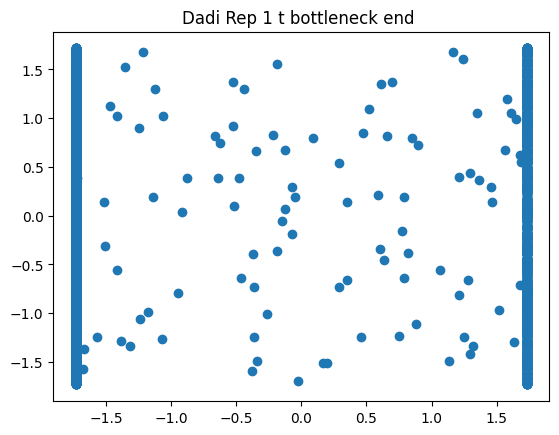

In [21]:
plt.figure()
plt.title("Dadi Rep 1 t bottleneck end ")
plt.scatter(post['training']['normalized_predictions']['dadi_rep1_t_bottleneck_end'], post['training']['normalized_targets']['simulated_params_t_bottleneck_end'])
plt.show()

## Calculate the MSE for each analysis type and for each stage.

In [22]:
post['training']['normalized_predictions']

,dadi_rep1_N0,moments_rep1_N0,moments_rep1_FIM_element_0,moments_rep1_FIM_element_1,moments_rep1_FIM_element_2,moments_rep1_FIM_element_3,moments_rep1_FIM_element_4,moments_rep1_FIM_element_5,moments_rep1_FIM_element_6,moments_rep1_FIM_element_7,...,moments_rep2_N_recover,dadi_rep2_t_bottleneck_start,moments_rep2_t_bottleneck_start,dadi_rep2_t_bottleneck_end,moments_rep2_t_bottleneck_end,momentsLD_N0,momentsLD_Nb,momentsLD_N_recover,momentsLD_t_bottleneck_start,momentsLD_t_bottleneck_end
0,1.217103,1.306295,0.171484,0.183905,-0.192875,0.113817,0.017652,0.221500,0.779374,-0.174667,...,-1.231706,1.732051,1.732051,1.732051,1.732051,1.209230,1.621193,1.732051,1.732051,-1.732051
1,0.209906,0.303252,-4.356467,3.223130,3.748619,-3.794926,0.017900,-3.632185,-0.286583,1.886730,...,1.732051,-1.732051,-1.732051,-1.732051,-1.732051,0.873404,-1.732051,1.732051,-1.732051,-1.732051
2,1.163338,1.191788,0.260418,-0.213985,-0.232620,0.875074,0.017255,0.379069,-0.449028,-0.195902,...,1.732051,-1.732051,-1.732051,-1.732051,-1.732051,1.508438,1.732051,0.388023,0.903507,1.732051
3,-1.545515,-1.433175,0.200725,-0.265467,-0.210282,0.080884,0.017953,0.330748,0.212607,-0.185519,...,-1.732051,-1.732051,-1.732051,-1.732051,-1.732051,-1.647243,-1.732051,1.612880,-1.732051,-1.732051
4,0.550461,0.699366,0.212715,-0.131065,-0.217661,0.189362,0.017766,0.336286,0.725310,-0.189240,...,0.149888,1.732051,1.732051,-1.732051,1.732051,-0.113198,1.732051,1.536784,1.732051,-1.732051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,-1.193269,-1.087669,-0.311207,0.868228,0.518883,-0.069055,0.017792,-1.777715,-0.555042,0.190621,...,-0.451650,-0.892631,-1.586654,-1.732051,-1.732051,-0.344311,1.732051,-0.452658,1.732051,-1.732051
3796,1.435583,1.541044,0.203897,0.038318,-0.232127,0.297032,0.017349,0.359419,0.798264,-0.194517,...,-1.732051,1.732051,1.732051,1.732051,1.732051,0.703008,1.050931,1.732051,-1.645661,-1.732051
3797,1.132016,1.348046,0.219483,0.060214,-0.224473,0.508018,0.017504,0.334065,0.007550,-0.192467,...,0.052575,1.732051,1.732051,1.732051,1.732051,0.488423,-1.732051,0.139648,-0.549257,1.732051
3798,1.609461,1.722487,-0.184031,0.801851,0.050643,-0.943880,0.017787,-0.536421,0.653240,-0.008684,...,1.560459,-1.732051,-1.732051,-1.732051,-1.732051,1.073699,-1.732051,1.732051,-1.732051,-1.143558


In [23]:
post['training']['normalized_predictions']['dadi_rep1_N0']

0       1.217103
1       0.209906
2       1.163338
3      -1.545515
4       0.550461
          ...   
3795   -1.193269
3796    1.435583
3797    1.132016
3798    1.609461
3799   -1.196987
Name: dadi_rep1_N0, Length: 3800, dtype: float64

In [24]:
mean_squared_error(post['training']['normalized_predictions']['dadi_rep1_N0'], post['training']['normalized_targets']['simulated_params_N0'])

0.03624180286174283

In [25]:
np.min(post['training']['normalized_predictions']['dadi_rep1_N0'])

-1.7320508075688772

In [26]:
mean_squared_error(post['training']['normalized_predictions']['dadi_rep1_Nb'], post['training']['normalized_targets']['simulated_params_Nb'])

3.8411269590912993

In [27]:
np.max(post['training']['normalized_predictions']['dadi_rep1_Nb'])

1.7320508075688772

In [28]:
post['training']['normalized_targets']['simulated_params_Nb']

0       0.245951
1       0.803672
2       0.536936
3      -1.063479
4       1.205507
          ...   
3795   -1.091192
3796   -1.032302
3797    0.183597
3798   -1.517277
3799    0.644323
Name: simulated_params_Nb, Length: 3800, dtype: float64

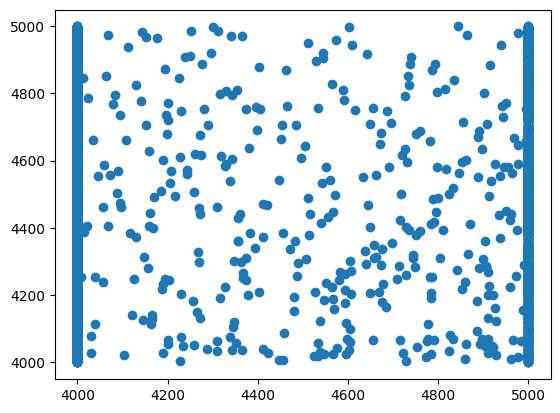

In [29]:
import matplotlib.pyplot as plt
plt.scatter(preproc['training']['predictions']['dadi_rep1_Nb'], preproc['training']['targets']['simulated_params_Nb'])

In [30]:
def plot_mse_and_sem(mse_results, sem_results, title, parameters):
    """
    Create a grouped bar plot showing MSE values with error bars for each parameter and analysis type.
    
    Parameters:
    -----------
    mse_results : dict
        Dictionary containing MSE values for each analysis type and parameter
    sem_results : dict
        Dictionary containing SEM values for each analysis type and parameter
    title : str
        Title for the plot
    parameters : list
        List of parameter names to plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure and axis with clean style
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Number of parameter groups and analysis types
    n_parameters = len(parameters)
    n_analyses = len(mse_results.keys())
    
    # Width of each bar and positions of the bars
    bar_width = 0.25
    index = np.arange(n_parameters)
    
    # Colors for different analysis types - using more distinct colors
    colors = ['#2ecc71', '#3498db', '#e74c3c']  # green, blue, red
    
    # Plot bars for each analysis type
    for i, (analysis_type, color) in enumerate(zip(mse_results.keys(), colors)):
        mse_values = []
        sem_values = []
        for param in parameters:
            mse_values.append(mse_results[analysis_type].get(param, 0))
            sem_values.append(sem_results[analysis_type].get(param, 0))
        
        positions = index + (i - 1) * bar_width
        bars = ax.bar(positions, mse_values, bar_width,
                     label=analysis_type, color=color, alpha=0.8)
        
        # Add error bars
        ax.errorbar(positions, mse_values, yerr=sem_values,
                   fmt='none', color='black', capsize=5)
    
    # Customize the plot
    ax.set_ylabel('Mean Squared Error (MSE)', fontsize=10)
    ax.set_title(title, fontsize=12, pad=20)
    ax.set_xticks(index)
    ax.set_xticklabels(parameters, fontsize=10)
    
    # Add legend with better positioning
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Add grid with light color
    ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

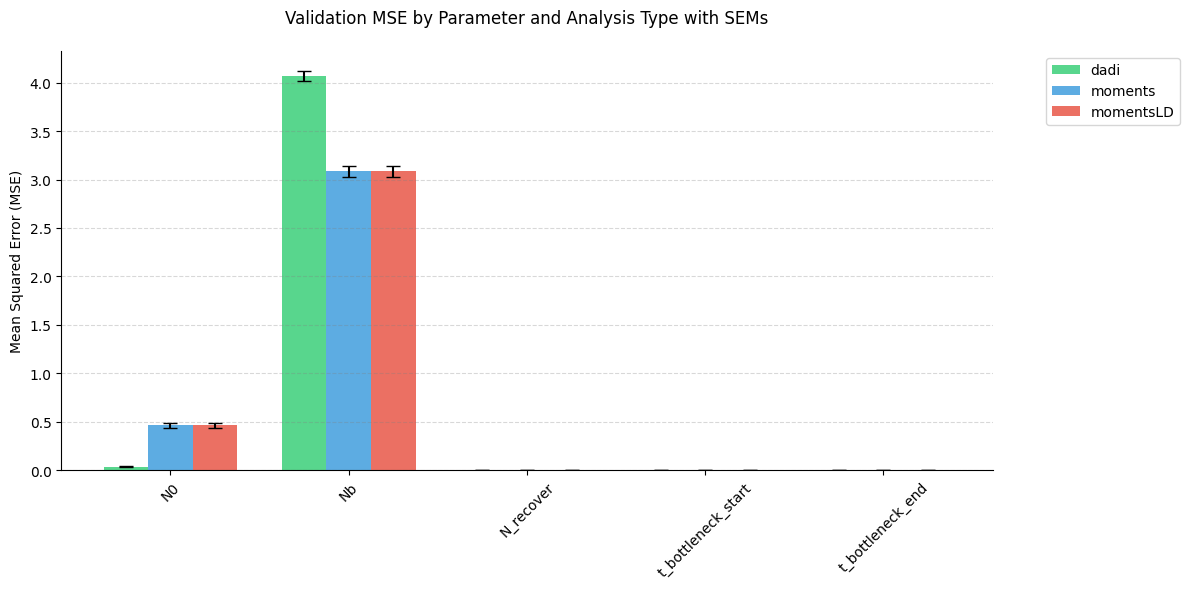

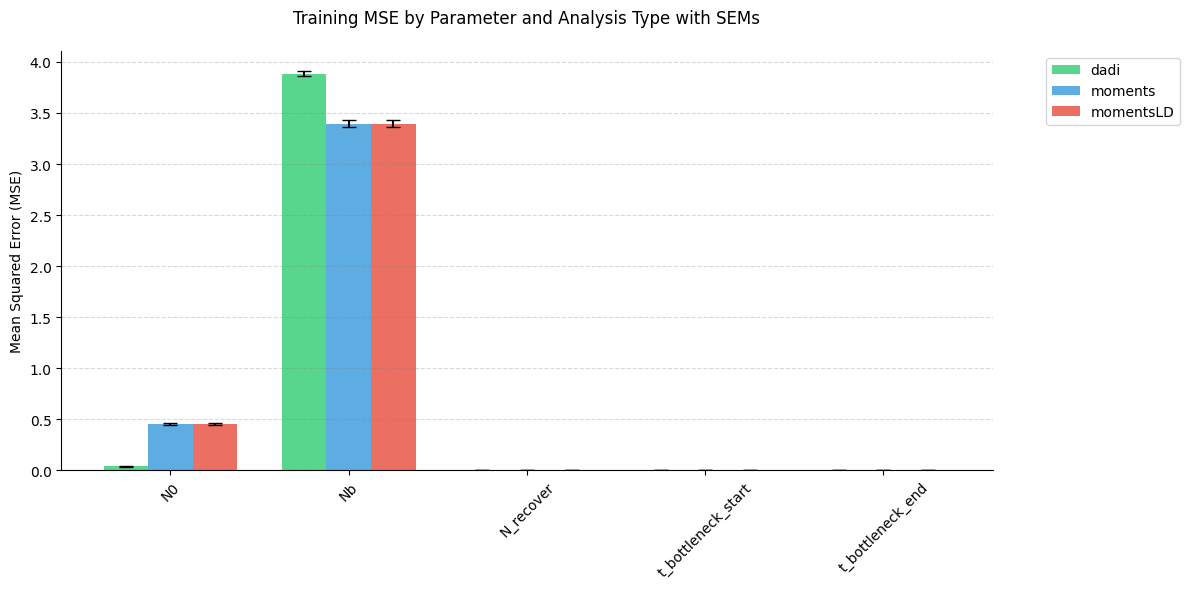

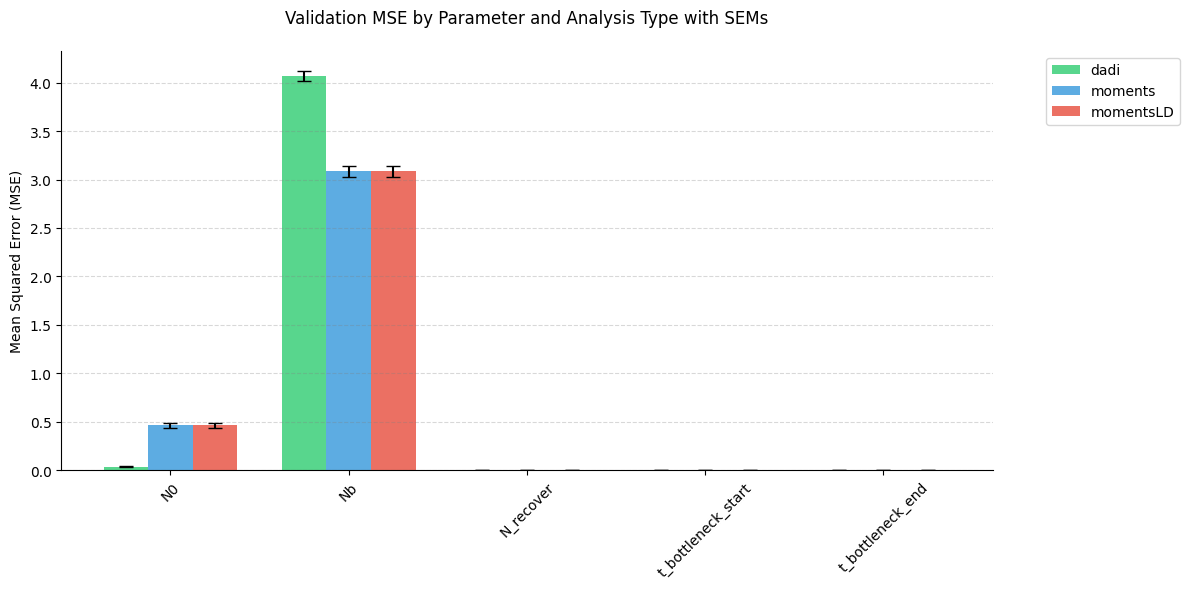

In [31]:
# Updated function to handle underscores in parameter names correctly
def calculate_mse_and_sem(post, key):
    predictions = post[key]['normalized_predictions']
    targets = post[key]['normalized_targets']
    mse_results = {}
    sem_results = {}

    for analysis_type in ['dadi', 'moments', 'momentsLD']:
        mse_values = {}
        sem_values = {}
        for column in predictions.columns:
            if column.startswith(analysis_type):
                # Extract parameter name after the last '_'
                param_name = "_".join(column.split('_')[-2:]) if 't_split' in column else column.split('_')[-1]
                target_column = f"simulated_params_{param_name}"
                if target_column in targets.columns:
                    mse = mean_squared_error(targets[target_column], predictions[column])
                    mse_values[param_name] = mse
                    sem = np.std(targets[target_column] - predictions[column]) / np.sqrt(len(targets[target_column]))
                    sem_values[param_name] = sem
        if mse_values:
            mse_results[analysis_type] = mse_values
            sem_results[analysis_type] = sem_values
    return mse_results, sem_results

# Parameters list
# parameters = ['Na', 'N1', 'N2', "t_split"]
parameters = experiment_config['parameters_to_estimate']

# Recalculate MSE and SEM for training and validation with the updated function
training_mse, training_sem = calculate_mse_and_sem(post, 'training')
validation_mse, validation_sem = calculate_mse_and_sem(post, 'validation')

# Re-plot with the fixed parameter handling
plot_mse_and_sem(training_mse, training_sem, "Training MSE by Parameter and Analysis Type with SEMs", parameters)
plot_mse_and_sem(validation_mse, validation_sem, "Validation MSE by Parameter and Analysis Type with SEMs", parameters)

In [32]:
training_mse

{'dadi': {'N0': 0.0398711737038705, 'Nb': 3.886364037267946},
 'moments': {'N0': 0.4560478689615833, 'Nb': 3.396391949996418},
 'momentsLD': {'N0': 0.4560478689615833, 'Nb': 3.396391949996418}}

In [33]:
validation_mse

{'dadi': {'N0': 0.0353514932020541, 'Nb': 4.066653379952551},
 'moments': {'N0': 0.4633902722733148, 'Nb': 3.0875125024947643},
 'momentsLD': {'N0': 0.4633902722733148, 'Nb': 3.0875125024947643}}

In [34]:
post['training']['predictions'].columns

Index(['dadi_rep1_N0', 'moments_rep1_N0', 'moments_rep1_FIM_element_0',
       'moments_rep1_FIM_element_1', 'moments_rep1_FIM_element_2',
       'moments_rep1_FIM_element_3', 'moments_rep1_FIM_element_4',
       'moments_rep1_FIM_element_5', 'moments_rep1_FIM_element_6',
       'moments_rep1_FIM_element_7', 'moments_rep1_FIM_element_8',
       'moments_rep1_FIM_element_9', 'dadi_rep1_Nb', 'moments_rep1_Nb',
       'dadi_rep1_N_recover', 'moments_rep1_N_recover',
       'dadi_rep1_t_bottleneck_start', 'moments_rep1_t_bottleneck_start',
       'dadi_rep1_t_bottleneck_end', 'moments_rep1_t_bottleneck_end',
       'dadi_rep2_N0', 'moments_rep2_N0', 'moments_rep2_FIM_element_0',
       'moments_rep2_FIM_element_1', 'moments_rep2_FIM_element_2',
       'moments_rep2_FIM_element_3', 'moments_rep2_FIM_element_4',
       'moments_rep2_FIM_element_5', 'moments_rep2_FIM_element_6',
       'moments_rep2_FIM_element_7', 'moments_rep2_FIM_element_8',
       'moments_rep2_FIM_element_9', 'dadi_rep2_

## Extracting Features

In [35]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/extracting_features.py \
 --postprocessing_results_filepath $SIM_DIRECTORY/postprocessing_results.pkl \
 --sim_directory $SIM_DIRECTORY

dict_keys(['parameter_names', 'target_names', 'training', 'validation'])
Training features shape: (3800, 45)
Validation features shape: (950, 45)
Training targets shape: (3800, 5)
Validation targets shape: (950, 5)


## Linear Evaluation

In [36]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type standard

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
Initializing LinearRegression with kwargs={}
PREDICTIONS SHAPE TRAINING: (3800, 5)
[0.93572725 0.79602038 0.48175763 ... 0.4926833  0.8048923  0.23347342]
[0.77119432 0.94384063 0.38544348 0.59203225 0.95664091 0.52872683
 0.30907553 0.32522262 0.33119135 0.80009654 0.69775138 0.19824711
 0.69166228 1.04504254 0.09201513 0.57209782 1.21207006 0.97679562
 0.24904621 0.94512294 0.02880413 0.47228012 1.13304427 0.36509845
 0.45746253 0.64642258 0.39329698 0.48935426 0.78626477 0.6653472
 1.10837617 0.20645764 0.53891028 0.28415364 0.45395699 0.83046991
 0.79082362 0.56419901 0.52285902 0.63279702 0.28154539 0.41997685
 0.41738217 0.60443065 0.77390541 0.74545093 0.642

### Ridge

In [64]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type ridge

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.14467e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.78763e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditio

### Lasso

In [65]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type lasso

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e+01, tolerance: 3.047e-01
  model = cd_fast.enet_coordinate_descent(
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

### Elastic Net

In [20]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type elasticnet

Model directory created/verified: split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.653e-01, tolerance: 2.811e-01
  model = cd_fast.enet_coordinate_descent(
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasin

## Random Forest

In [37]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/random_forest_evaluation.py \
    --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
    --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
    --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
    --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
    --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False

No hyperparameters specified. Running RandomizedSearchCV to find best hyperparameters...

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters found via RandomizedSearchCV: {'random_state': 295, 'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}

Initializing RandomForestRegressor with kwargs={'n_estimators': 200, 'max_depth': None, 'random_state': 295, 'min_samples_split': 10}

Random Forest predictions shape (training): (3800, 5)
Random Forest predictions shape (validation): (950, 5)

[0.18244899 0.1494625  0.11970068 ... 0.08458205 0.3331237  0.08097806]
[0.77521492 0.88364181 0.34379007 0.8372631  0.7484455  0.597180

## XGBoost

In [38]:
 !python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/xgboost_evaluation.py \
    --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
    --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
    --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
    --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
    --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False

No XGBoost hyperparameters specified. Running RandomizedSearchCV to find best hyperparameters...

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters found via RandomizedSearchCV: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

Initializing XGBRegressor with kwargs={'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'reg_lambda': 1, 'reg_alpha': 0}

XGBoost predictions shape (training): (3800, 5)
XGBoost predictions shape (validation): (950, 5)

[0.

## Neural Network

In [ ]:
    # parser.add_argument("--experiment_directory", type=str, required=True)
    # parser.add_argument("--model_config_file", type=str, required=True)
    # parser.add_argument("--features_file", type=str, required=True)
    # parser.add_argument("--color_shades", type=str, required=True)
    # parser.add_argument("--main_colors", type=str, required=True)

In [40]:
preproc['training']['predictions']

,dadi_rep1_N0,moments_rep1_N0,moments_rep1_FIM_element_0,moments_rep1_FIM_element_1,moments_rep1_FIM_element_2,moments_rep1_FIM_element_3,moments_rep1_FIM_element_4,moments_rep1_FIM_element_5,moments_rep1_FIM_element_6,moments_rep1_FIM_element_7,...,moments_rep2_N_recover,dadi_rep2_t_bottleneck_start,moments_rep2_t_bottleneck_start,dadi_rep2_t_bottleneck_end,moments_rep2_t_bottleneck_end,momentsLD_N0,momentsLD_Nb,momentsLD_N_recover,momentsLD_t_bottleneck_start,momentsLD_t_bottleneck_end
0,9702.694916,9754.190010,0.171484,0.183905,-0.192875,0.113817,0.017652,0.221500,0.779374,-0.174667,...,6144.437015,2000.000000,2000.000000,1000.0,1000.0,9698.149251,4967.998186,7000.000000,2000.000000,800.000000
1,9121.189512,9175.082477,-4.356467,3.223130,3.748619,-3.794926,0.017900,-3.632185,-0.286583,1.886730,...,7000.000000,1500.000000,1500.000000,800.0,800.0,9504.259752,4000.000000,7000.000000,1500.000000,800.000000
2,9671.653561,9688.079053,0.260418,-0.213985,-0.232620,0.875074,0.017255,0.379069,-0.449028,-0.195902,...,7000.000000,1500.000000,1500.000000,800.0,800.0,9870.897294,5000.000000,6612.012598,1880.410014,1000.000000
3,8107.696297,8172.555975,0.200725,-0.265467,-0.210282,0.080884,0.017953,0.330748,0.212607,-0.185519,...,6000.000000,1500.000000,1500.000000,800.0,800.0,8048.963538,4000.000000,6965.598433,1500.000000,800.000000
4,9317.808880,9403.778880,0.212715,-0.131065,-0.217661,0.189362,0.017766,0.336286,0.725310,-0.189240,...,6543.269019,2000.000000,2000.000000,800.0,1000.0,8934.645373,5000.000000,6943.631374,2000.000000,800.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,8311.065828,8372.034258,-0.311207,0.868228,0.518883,-0.069055,0.017792,-1.777715,-0.555042,0.190621,...,6369.619950,1621.159805,1520.986198,800.0,800.0,8801.211991,5000.000000,6369.328998,2000.000000,800.000000
3796,9828.834232,9889.722341,0.203897,0.038318,-0.232127,0.297032,0.017349,0.359419,0.798264,-0.194517,...,6000.000000,2000.000000,2000.000000,1000.0,1000.0,9405.881990,4803.377615,7000.000000,1512.469238,800.000000
3797,9653.569808,9778.294588,0.219483,0.060214,-0.224473,0.508018,0.017504,0.334065,0.007550,-0.192467,...,6515.177039,2000.000000,2000.000000,1000.0,1000.0,9281.991200,4000.000000,6540.312769,1670.721638,1000.000000
3798,9929.222851,9994.478212,-0.184031,0.801851,0.050643,-0.943880,0.017787,-0.536421,0.653240,-0.008684,...,6950.465700,1500.000000,1500.000000,800.0,800.0,9619.900666,4000.000000,7000.000000,1500.000000,833.976648


In [41]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/setup_trainer.py \
    --experiment_directory $EXPERIMENT_DIRECTORY \
    --model_config_file $MODEL_CONFIG_FILEPATH \
    --features_file $SIM_DIRECTORY/features_and_targets.pkl \
    --color_shades $SIM_DIRECTORY/color_shades.pkl \
    --main_colors $SIM_DIRECTORY/main_colors.pkl

/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /projects/kernlab/akapoor/Demographic_Inference/snak ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | network   | Sequential | 625    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
625       Trainable params
0         Non-trainable params
625       Total params
0.003     Total estimated m

In [75]:
preproc['training']['predictions'].columns

Index(['dadi_rep1_N0', 'moments_rep1_N0', 'dadi_rep1_Nb', 'moments_rep1_Nb',
       'dadi_rep1_N_recover', 'moments_rep1_N_recover',
       'dadi_rep1_t_bottleneck_start', 'moments_rep1_t_bottleneck_start',
       'dadi_rep1_t_bottleneck_end', 'moments_rep1_t_bottleneck_end',
       'dadi_rep2_N0', 'moments_rep2_N0', 'dadi_rep2_Nb', 'moments_rep2_Nb',
       'dadi_rep2_N_recover', 'moments_rep2_N_recover',
       'dadi_rep2_t_bottleneck_start', 'moments_rep2_t_bottleneck_start',
       'dadi_rep2_t_bottleneck_end', 'moments_rep2_t_bottleneck_end',
       'momentsLD_N0', 'momentsLD_Nb', 'momentsLD_N_recover',
       'momentsLD_t_bottleneck_start', 'momentsLD_t_bottleneck_end',
       'simulation_id'],
      dtype='object')

In [20]:
import torch
print("Is CUDA available?", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Is CUDA available? False
Number of GPUs: 0


/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


RuntimeError: No CUDA GPUs are available